In [1]:
#Libraries
% matplotlib inline
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import locale
import pylab
import random
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import itertools
from scipy.misc import derivative
from scipy.interpolate import UnivariateSpline

# import findiff
# This is needed to use local settings to write point or comma as decimal separator in output files
_locale_radix = locale.localeconv()['decimal_point']

In [2]:
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')

Functions of general purpose:

In [3]:
def read_first_last_N_lines_from_file(in_file, N, last=False):
    with open(in_file) as myfile:
        if last:
            return [x.strip() for x in list(myfile)][-N:]
        return [next(myfile).strip() for x in range(N)]

In [4]:

def get_1d_range(s, w, n, wmin=0, wmax=100):
    sr = np.array(s)
    wr = np.array(w)
    nr = np.zeros(wr.shape)
    for ix, iy in np.ndindex(wr.shape):
        nr[ix, iy] = n[ix]
    s1p = sr.flatten()
    w1p = wr.flatten()
    n1p = nr.flatten()
    indx = np.where(np.logical_and(w1p >= wmin, w1p <= wmax))
    n1d = n1p[indx[:]]
    s1d = s1p[indx[:]]
    w1d = w1p[indx[:]]
    return s1d, w1d, n1d


# Interpolation subroutines

We provide subroutines aimed to interpolate data points and to make operations with these interpolations.

In [5]:
def interpola(dat_x, dat_y, ndata=1, kind="cubic", npoints=1000):
    y = [interp1d(dat_x[i], dat_y[i], kind) for i in range(ndata)]
    x = [np.linspace(dat_x[i][0], dat_x[i][-1], npoints) for i in range(ndata)]
    return x, y




This are subroutine to allow Pad'e analysis interpolations:

This is to find crossing between general functions instead between data.

In [6]:
def crossings_func(x, f, n, wmin=None, wmax=None):
    #It does not work very well!
    if wmin is None or wmax is None:
        xr = x
    else:
        xr = np.linspace(wmin, wmax, 100)
    y = [f[i](xr) for i in range(len(f))]
    idx = [np.argwhere(np.diff(np.sign(y[i] - y[i - 1]))).flatten() for i in range(1, len(f))]
    L_cross = np.array([np.log(np.sqrt(n[i - 1] * n[i])) for i in range(1, len(f))])
    w_cr = np.array([xr[idx[i]] for i in range(0, len(f) - 1)]).ravel()
    return L_cross, w_cr

To find crossing between data instead of 

In [7]:
def crossings(xlist, ylist, n, wmin=None, wmax=None):
    #It does not work very well!
    x, f = interpola(xlist, ylist, ndata=len(xlist), kind="cubic")
    if wmin is None or wmax is None:
        xr = x
    else:
        xr = np.linspace(wmin, wmax, 100)
    y = [f[i](xr) for i in range(len(f))]
    idx = [np.argwhere(np.diff(np.sign(y[i] - y[i - 1]))).flatten() for i in range(1, len(f))]
    L_cross = np.array([np.log(np.sqrt(n[i - 1] * n[i])) for i in range(1, len(f))])
    #     print(idx, x)
    w_cr = np.array([xr[idx[i]] for i in range(0, len(f) - 1)]).ravel()
    #     print(w_cr)
    #     w_cr_av = [sum(w_cr[i][j] for j in range(w_cr[i].shape[0])/w_cr[i].shape[0])]
    #     w_cr = x[idx[:]]
    return L_cross, w_cr

# Fittings

First we define functions:

In [8]:
def func_p(x, a, eta, y):
    return (a + eta * x ** y)


def func_exp(x, a, eta, y):
    return (a + eta * np.exp(-np.abs(y) * (1 / x)))


def func_s(x, a0, a1, a2, a3):
    a = [a0, a1, a2, a3]
    r = (a[0] + a[1] * x) * (1 + a[2] * np.sqrt(x) + a[3] * x)
    return r


def func_line(x, a0, a1):
    a = [a0, a1]
    r = a[0] + a[1] * x
    return r

The following are subroutines devoted to perforfs different types of fittings. 

In [9]:
# This is to compute polynomial fittings and give the errors (sigmas).
# Please note that numpy.polyfits requires inverse of sigmas!
def polynomial_fit_witherrors(x, y, nor=2, y_err=False):
    if y_err is False:
        z, pcov = np.polyfit(x, y, nor, cov=True)
    else:
        print("y_err should contain sigmas, not 1/sigmas")
        z, pcov = np.polyfit(x, y, nor, cov=True, w=1 / y_err)
    #     print(z)
    perr = np.sqrt(np.diag(pcov))
    p = np.poly1d(z)
    return p, perr

In [10]:
# This is another subroutine to compute the lineal fittings but with a full control over everything.
def fitea_polynomy(x, y, y_err=False):
    igu = [-1, 10]
    if y_err is False:
        popt, pcov = curve_fit(func_line, x, y, igu)
    else:
        popt, pcov = curve_fit(func_line, x, y, igu, sigma=y_err, maxfev=10000, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    r = y - func_line(x, *popt)
    res = r / y_err
    chisq = sum((res) ** 2)
    #     print("chisq test gives",chisq/(y.shape[0]-2))
    #     print(round(T,2))
    return popt, perr, chisq / (np.array(y).shape[0] - 2), res

In [11]:
def fitea_power(x, y, y_err=False, a_i=1, eta_i=1, exp_i=2, law="power"):
    a = a_i
    eta = eta_i
    exp = exp_i
    igu = [a, eta, exp]
    if law is "power":
        if y_err is False:
            popt, pcov = curve_fit(func_p, x, y, igu, maxfev=100000)
        else:
            popt, pcov = curve_fit(func_p, x, y, igu, sigma=y_err, maxfev=100000)
    if law is "exp":
        if y_err is False:
            popt, pcov = curve_fit(func_exp, x, y, igu, maxfev=100000)
        else:
            popt, pcov = curve_fit(func_exp, x, y, igu, sigma=y_err, maxfev=100000)
    perr = np.sqrt(np.diag(pcov))
    r = y - func_p(x, *popt)
    res = r / y_err
    chisq = sum((res) ** 2)
    print("chisq test gives", chisq / (y.shape[0] - 2))
    #     print(round(T,2))
    return popt, perr, chisq / (y.shape[0] - 2), res


def fitea_power_s(x, y, y_err=False):
    igu = [0.5, 0.2, 0.5, 0.1]
    if y_err is False:
        popt, pcov = curve_fit(func_s, x, y, igu)
    else:
        popt, pcov = curve_fit(func_s, x, y, igu, sigma=y_err, maxfev=1000000)
    perr = np.sqrt(np.diag(pcov))
    r = y - func_s(x, *popt)
    res = r / y_err
    chisq = sum((res) ** 2)
    print("chisq test gives", chisq / (y.shape[0] - 2))
    #     print(round(T,2))
    return popt, perr, chisq / (y.shape[0] - 2), res

# Scaling hypothesis

This are subroutine to perform a finite size scaling.

In [12]:
def data_fss(x1, x2, y, yerr, x1min, x1max):
    # We compute new arrays where x1 is restricted to the desired interval     
    indx = [np.where(np.logical_and(x1[i] >= x1min, x1[i] <= x1max)) for i in range(len(x1))]
    x1_n = [x1[i][indx[i]] for i in range(len(x1))]
    y_n = [y[i][indx[i]] for i in range(len(y))]
    yerr_n = [yerr[i][indx[i]] for i in range(len(y))]
    # Now, we construct three 1d arrays p1, p2 and q. The array q contains the quantity over which 
    # finite size analysis is performer. The p1 and p2 contains the values of parameter and size for
    # each of the entries of q
    x = np.concatenate(x1_n).ravel()
    y = np.concatenate([x2[i] * np.ones(len(x1_n[i])) for i in range(len(x1_n))]).ravel()
    f = np.concatenate(y_n).ravel()
    ferr = np.concatenate(yerr_n).ravel()
    return x, y, f, ferr



In [13]:
class fitea_order_and:
    #
    # 
    def __init__(self, nrho, ns, nb):
        self.nrho = nrho
        self.ns = ns
        self.nb = nb
        self.nt = ns + nrho + nb
        if ns < 2:
            print("WARNING: the minimum ns should be 2 to include scaling variable!")

    def func2(self, x, *para):
        a = para[0:self.ns]
        d = para[self.ns:self.ns + self.nrho]
        b = para[self.ns + self.nrho: self.ns + self.nrho + self.nb]
        nu = para[self.ns + self.nrho + self.nb]
        wc = para[self.ns + self.nrho + self.nb + 1]
        #         print(a,d,nu,wc)
        rho = (x[0] - wc) + sum(d[i] * (x[0] - wc) ** (i + 2) for i in range(self.nrho))
        xs = rho * x[1] ** (1 / nu)
        beta = sum(b[i] * (x[0] - wc) ** (i) for i in range(self.nb))

        if self.nb == 0:
            f = sum(a[i] * xs ** i for i in range(self.ns))
        elif self.nb > 0:
            y = para[-1]
            f = sum(a[i] * xs ** i for i in range(self.ns)) * (1 + beta * x[1] ** (-np.abs(y)))
        return f

    def fitea_p(self, x_opt, y_opt, y_err, w_i=17.5, nu_i=1, y_i=-0.5, verbose=True):
        #        igu = [1] * (self.nrho+self.ns+self.nb+ self.nir)
        igu = [np.random.rand() / 10 ** i for i in range((self.nrho + self.ns + self.nb))]
        #         print(igu)
        igu.extend([nu_i, w_i])
        if self.nb > 0:
            igu.append(y_i)
        popt, pcov = curve_fit(self.func2, x_opt, y_opt, igu, sigma=y_err, absolute_sigma="False", maxfev=1000000)
        perr = np.sqrt(np.diag(pcov))
        r = y_opt - self.func2(x_opt, *popt)
        res = r / y_err
        chisq = sum((res) ** 2) / (y_err.shape[0] - len(igu))
        print("numero de puntos", y_err.shape[0])
        #print(y_err**2)
        if verbose:
            for i in range(len(igu)):
                print(popt[i], "+-", perr[i])
            print("chisq/df", chisq)
        return popt, perr, chisq, res

    def give_c(self, x, *para):
        a = para[0:self.ns]
        d = para[self.ns:self.ns + self.nrho]
        b = para[self.ns + self.nrho: self.ns + self.nrho + self.nb]
        nu = para[self.ns + self.nrho + self.nb]
        wc = para[self.ns + self.nrho + self.nb + 1]
        #         print(a,d,nu,wc)
        rho = (x[0] - wc) + sum(d[i] * (x[0] - wc) ** (i + 2) for i in range(self.nrho))
        xs = rho * x[1] ** (1 / nu)
        beta = sum(b[i] * (x[0] - wc) ** (i) for i in range(self.nb))
        if self.nb == 0:
            f = 0
        elif self.nb > 0:
            y = para[-1]
            f = sum(a[i] * xs ** i for i in range(self.ns)) * (beta * x[1] ** (-np.abs(y)))
        return f, nu, wc

    def sc_function(self, *para):
        if self.nrho > 0:
            print("WARNING: the scaling function also dependes on W-W_c!")
        a = para[0:self.ns]
        #         print(a,d,nu,wc)
        f = lambda x: sum(a[i] * x ** i for i in range(self.ns))
        return f

    def give_scalingv(self, x, *para):
        a = para[0:self.ns]
        d = para[self.ns:self.ns + self.nrho]
        b = para[self.ns + self.nrho: self.ns + self.nrho + self.nb]
        nu = para[self.ns + self.nrho + self.nb]
        wc = para[self.ns + self.nrho + self.nb + 1]
        #         print(a,d,nu,wc)
        rho = (x - wc) + sum(d[i] * (x - wc) ** (i + 2) for i in range(self.nrho))
        return rho


def separa(x, s, y, y_e):
    xp = []
    sp = []
    yp = []
    yp_e = []
    nc = 0
    for i in range(len(x) - 1):
        if x[i] > x[i + 1]:
            xp.append(x[nc:i + 1])
            yp.append(y[nc:i + 1])
            yp_e.append(y_e[nc:i + 1])
            sp.append(s[nc:i + 1])
            nc = i + 1
    xp.append(x[nc:])
    yp.append(y[nc:])
    sp.append(s[nc:])
    yp_e.append(y_e[nc:])
    return xp, sp, yp, yp_e



Definitions of the colours throug all the computations

In [15]:
color = ['turquoise', 'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
         'tab:blue', 'goldenrod', 'tab:orange', 'tab:red']

# Random-Regular Graph with $k=2$.

We analyze the data for Random-regular graph which should be contained in the file where this notebook is. Take care with different set of data. The data for D1, D2 or D\infty may not contain the same information in all files. One could check each of the data with the .py file which has been computed for more info.

Te structure of this notebook is the following. For each plot, we always read the data and perform analysis. We try to diverde all the following code in plots. The index is the following:

- Participation ratio $S$

    - Correlated volume
    - Figure 1: $S$ and its derivative
    - Scaling of $S$
    - Maxima and its location for $D_1$

- Second momenta $I_2$ and $I_\infty$

    - Scaling of $I_2$
    
- Maxima of $S$ and $I_2$

    - Extraploation of the maxima

# Derivative of entropy 

In [16]:
n = [124, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]
npr = len(n)
d = 3
# npoints = 20
fn = 'rrg_d3'
files = ['./av_n' + str(n[i]) + fn + '.dat' for i in range(npr)]

xfiles = [read_first_last_N_lines_from_file(files[i], 200, last=True) for i in range(npr)]

xdat = [np.loadtxt(xfiles[i][:]) for i in range(npr)]
w = [xdat[i][:, 0] for i in range(npr)]



In [17]:
sdln = np.array([xdat[i][:, 3] / (np.log(n[i])) ** 1. for i in range(npr)])
sdln_error = np.array([xdat[i][:, 4] / np.log(n[i]) ** 1 for i in range(npr)])

In [18]:
wdiff = [(w[i][2:] - w[i][0:-2]) for i in range(npr)]

ds = [(sdln[i][2:] - sdln[i][:-2]) / wdiff[i] for i in range(npr)]
ds_error = [(sdln_error[i][2:] + sdln_error[i][0:-2]) / wdiff[i] for i in range(npr)]
w_ds = [(w[i][2:] + w[i][0:-2]) / 2 for i in range(npr)]
xds_int, ds_int = interpola(w_ds, ds, ndata=npr, kind="quadratic")

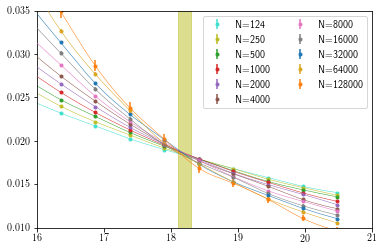

In [19]:
fig, ax1 = plt.subplots()
for i in range(npr):
    ax1.errorbar(w_ds[i], ds[i], yerr=ds_error[i], fmt='.', label="N=" + str(n[i]), color=color[i])
    ax1.plot(xds_int[i], ds_int[i](xds_int[i]), linewidth=0.5, color=color[i], zorder=i)
ax1.axvspan(18.1, 18.3, alpha=0.5, color='tab:olive')
# ax2.set_xlabel("$W$", fontsize=30)
# ax2.set_ylabel("$s'$", fontsize=30)
ax1.set_xlim(16, 21)
ax1.set_ylim(0.01, 0.035)
ax1.legend(ncol=2, loc="upper right", fontsize=10)

#ax1.axvspan(0, 10, facecolor='green', alpha=0.5)
#plt.savefig("D1_combined.pdf", bbox_inches='tight')

# Esxtrapolation of crossing

In [35]:
n = [124, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
npr = len(n)
d = 3
# npoints = 20
fn = 'rrg_d3'
files = ['./av_n' + str(n[i]) + fn + '.dat' for i in range(npr)]

# f = [ open(fdat) for fdat in files]

xfiles = [read_first_last_N_lines_from_file(files[i], 200, last=True) for i in range(npr)]
xdat = [np.loadtxt(xfiles[i][:]) for i in range(npr)]
w = [xdat[i][:, 0] for i in range(npr)]

sdln = np.array([xdat[i][:, 3] / (np.log(n[i])) ** 1. for i in range(npr)])
sdln_error = np.array([xdat[i][:, 4] / np.log(n[i]) ** 1 for i in range(npr)])

wdiff = [(w[i][2:] - w[i][0:-2]) for i in range(npr)]

ds = [(sdln[i][2:] - sdln[i][:-2]) / wdiff[i] for i in range(npr)]
ds_error = [(sdln_error[i][2:] + sdln_error[i][0:-2]) / wdiff[i] for i in range(npr)]
w_ds = [(w[i][2:] + w[i][0:-2]) / 2 for i in range(npr)]
xds_int, ds_int = interpola(w_ds, ds, ndata=npr, kind="quadratic")

In [36]:
L_cr, w_cr = crossings(w_ds[:], ds[:], n[:], wmin=15, wmax=20.0)
w_cr = [sum(w_cr[i]) / w_cr[i].shape[0] for i in range(len(w_cr))]
for i in range(len(L_cr)):
    print(L_cr[i], w_cr[i])
#p = polynomial_fit(1/L_cr,  w_cr, 2)
#print(w_cr_av)

5.170871241733642 18.88888888888889
5.868034508142219 18.434343434343432
6.561181688702164 18.535353535353536
7.2543288692621095 18.18181818181818
7.947476049822055 17.929292929292927
8.640623230382001 18.434343434343432
9.333770410941945 17.626262626262626
10.02691759150189 18.333333333333332
10.720064772061836 18.249158249158246


/home/pino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [37]:
L_cr_e, w_cr_e = crossings(w_ds[0::2], ds[0::2], n[0::2], wmin=15, wmax=20.0)
L_cr_o, w_cr_o = crossings(w_ds[1::2], ds[1::2], n[1::2], wmin=15, wmax=20.0)
L_cr = np.concatenate([L_cr_o, L_cr_e])
w_cr = np.concatenate([w_cr_o, w_cr_e])
#w_cr = [ sum(w_cr[i])/w_cr[i].shape[0]  for i in range(len(w_cr))]
for i in range(len(L_cr)):
    print(L_cr[i], w_cr[i])
#p = polynomial_fit(1/L_cr,  w_cr, 2)
#print(w_cr_av)

6.214608098422191 18.434343434343432
7.600902459542082 18.03030303030303
8.987196820661973 17.77777777777778
10.373491181781864 18.232323232323232
5.517444832013615 18.484848484848484
6.907755278982137 18.282828282828284
8.294049640102028 18.18181818181818
9.680344001221918 18.08080808080808


In [38]:
#yc1 = np.array([ds_int[i](w_cr[i]) for i in range(npr-1)])

#yc1 = np.array([ds_int[i](w_cr[i]) for i in range(npr-1)])
nf = -0
popt, perr, rc, res = fitea_power(1 / np.array(L_cr[:]), np.array(w_cr[:]), np.array(w_cr[:]),
                                  a_i=15, eta_i=10, exp_i=0.1, law="power")

a = popt[0]
b = popt[1]
exp = popt[2]
print(a, b, exp)
print(perr)

xd_shift = np.linspace(0.0, 1 / L_cr[0] + 0.1, 100)
y_p_shift = func_p(xd_shift, a, b, exp)



chisq test gives 8.374799140795146e-05
17.994935197884455 505.0323852439602 4.004991698617979
[2.59652673e-01 4.48034789e+03 5.35767212e+00]


In [39]:
nf = -0
popt, perr, rc, res = fitea_power(1 / np.array(L_cr[:]), np.array(w_cr[:]), np.array(w_cr[:]),
                                  a_i=18, eta_i=1, exp_i=0.001, law="exp")

a = popt[0]
b = popt[1]
exp = popt[2]
print(a, b, exp)
print(perr)

xd_shift_exp = np.linspace(0.0001, 1 / L_cr[0] + 0.1, 100)
y_p_shift_exp = func_exp(xd_shift, a, b, exp)



chisq test gives 0.14009889334639405
18.024211395708708 25.448278290677166 0.707742988585663
[  0.17003244 108.03822479   0.78781398]


/home/pino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


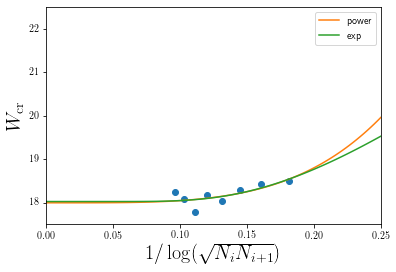

In [40]:
fig, ax1 = plt.subplots()

plt.plot(1 / L_cr, w_cr, "o")
plt.plot(xd_shift, y_p_shift, label="power")
plt.plot(xd_shift_exp, y_p_shift_exp, label="exp")
#fig.suptitle("Shift of critical point for different sizes", fontsize=28)      
ax1.set_xlabel("$1/\\log(\\sqrt{N_i N_{i+1}})$", fontsize=20)
ax1.set_ylabel("$W_{\\rm cr}$", fontsize=20)
ax1.set_xlim(0.0, 0.25)
ax1.set_ylim(17.5, 22.5)
plt.savefig("shiftsp.pdf")
ax1.legend()

# Scaling

In [34]:
nsc = 1
nf = 20
x1, x2, y, yerr = data_fss(w_ds[nsc:nf], np.log(n[nsc:nf]), ds[nsc:nf], ds_error[nsc:nf], 15.0, 22)
#x1, x2, y, yerr = data_fss(w_p[2::],np.log(n[2::]),ds_p[2::], ds_error_p[2::],14,21)
x_opt = [x1, x2]
y_opt = y
y_opt_err = yerr
# 
fitting = fitea_order_and(0, 4, 0)

para, error, chisq, res = fitting.fitea_p(x_opt, y_opt, y_opt_err, w_i=18.15, nu_i=1.2, y_i=2)
print(para)

numero de puntos 99
0.018426748161847945 +- 5.586642511236506e-05
-0.0003803293567946857 +- 8.392642142226195e-06
6.053051620620045e-06 +- 3.0607805029854313e-07
-7.086741029162211e-08 +- 8.498294415362692e-09
0.9302157926647057 +- 0.01090745582160402
18.218846702125532 +- 0.016913584752899523
chisq/df 1.770650163333137
[ 1.84267482e-02 -3.80329357e-04  6.05305162e-06 -7.08674103e-08
  9.30215793e-01  1.82188467e+01]


0.01842674826119692 -0.0003803293594884449 6.053051963109932e-06 -7.086742032607062e-08 0.9302157946179185 18.218846662009977
-32.05192861138954 25.06620489843908


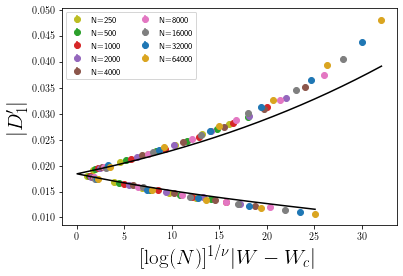

In [32]:

#fitting = fitea_order_alb(0,3,1,0)

print(*para)
#xsp = np.linspace(-20,20,100)
ydel, nu, wc = fitting.give_c(x_opt, *para)
nu = 1
# print(nu,wc)
# print(ydel)
f_sc = fitting.sc_function(*para)
yco = y_opt - ydel

xpinta, lpinta, ypinta, ypinta_e = separa(x_opt[0], x_opt[1], yco, y_opt_err)

#-----------------------------------------------------

xmin = (xpinta[-1][0] - wc) * lpinta[-1][0] ** (1 / nu)
xmax = (xpinta[-1][-1] - wc) * lpinta[-1][-1] ** (1 / nu)
xd = np.linspace(xmin, xmax, 1000)

print(xmin, xmax)
fig, ax1 = plt.subplots()
for i in range(0, len(xpinta)):
    plt.errorbar(np.abs(xpinta[i] - wc) * lpinta[i] ** (1 / nu), ypinta[i], yerr=ypinta_e[i], fmt="o",
                 label="N=" + str(n[nsc + i]), color=color[nsc + i])
plt.plot(np.abs(xd), f_sc(xd), linewidth=1.5, color="black", zorder=100)
#ax1.set_xlim(15,23.5)
#ax1.set_ylim(2.,3.)   
ax1.legend(ncol=2, fontsize=8)
ax1.set_xlabel("$[\log(N)]^{1/\\nu}|W-W_c|$", fontsize=21)
ax1.set_ylabel("$|D_1^{\prime}|$", fontsize=21)
plt.savefig("scaling.png")

handles, labels = ax1.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
plt.savefig("scaling.pdf", bbox_inches='tight')
# use them in the legend

# --------------------------------------------------------
